

FILE: demo_imgs/hypersim/frame.0004.color.jpg

rotation by 90 degrees
kernel unchanged when rotated by 90


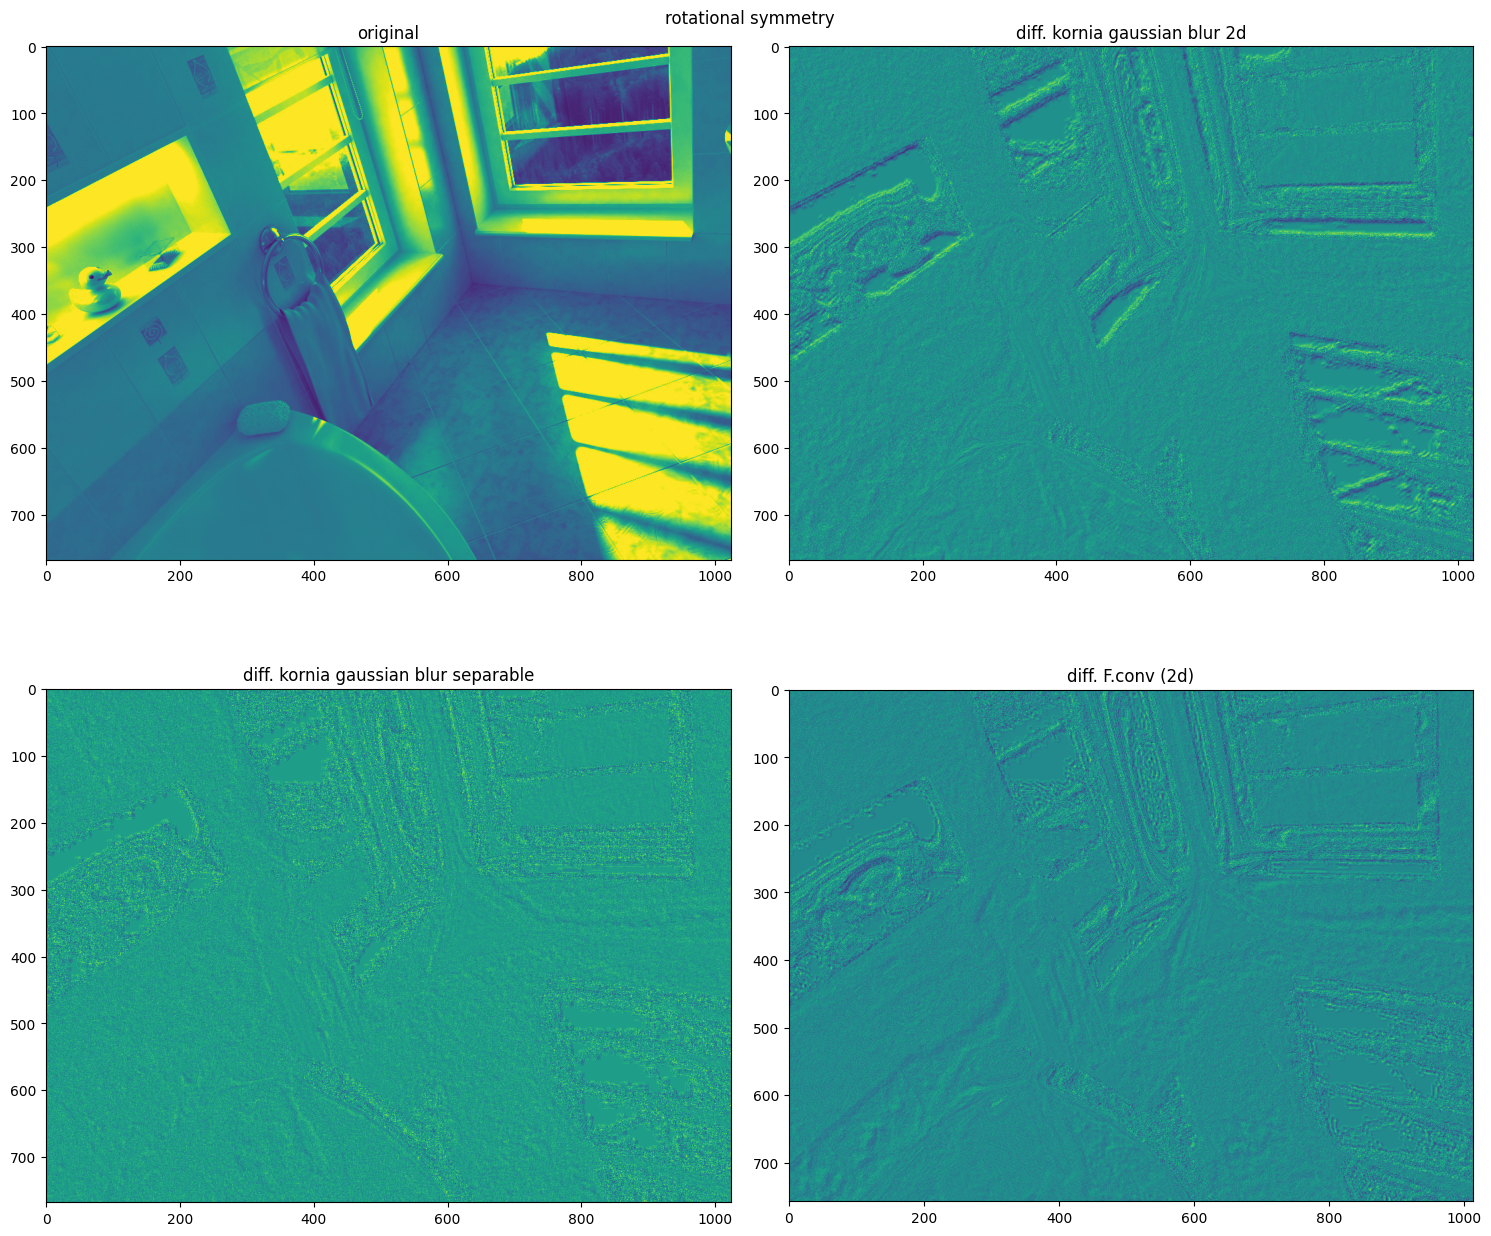

rotation by 180 degrees
kernel unchanged when rotated by 90


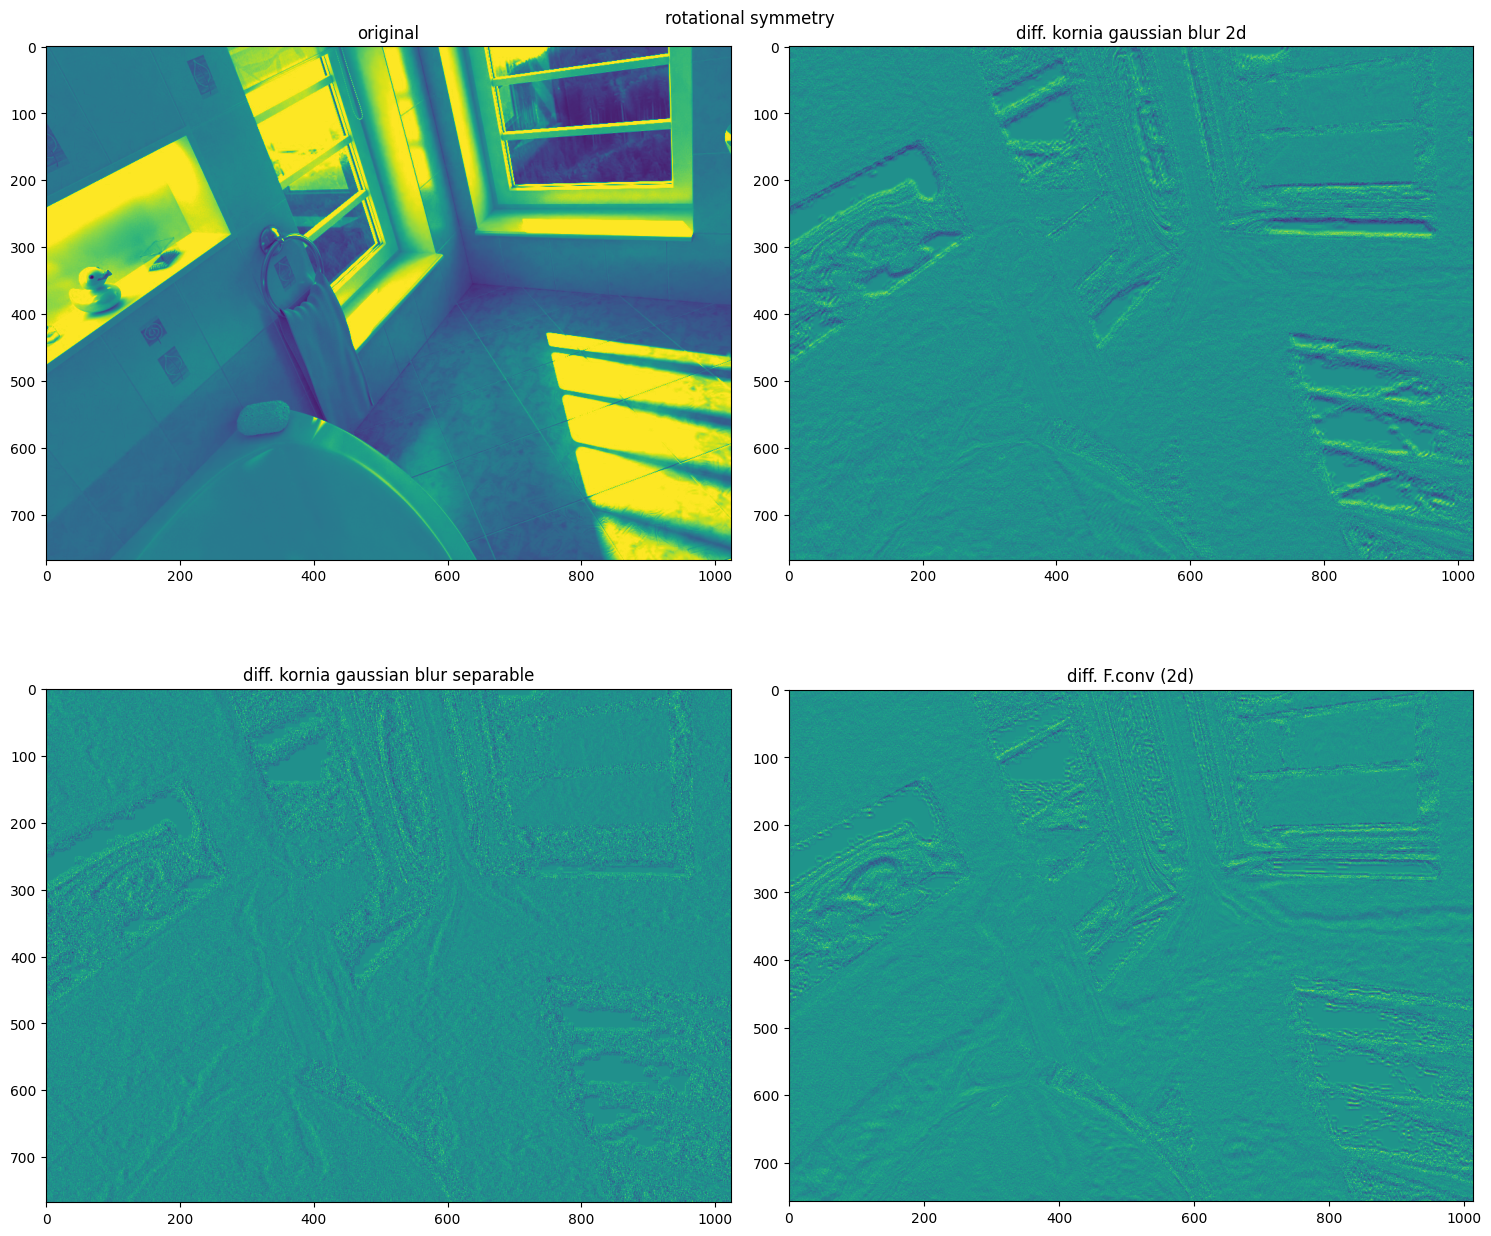

rotation by 270 degrees
kernel unchanged when rotated by 90


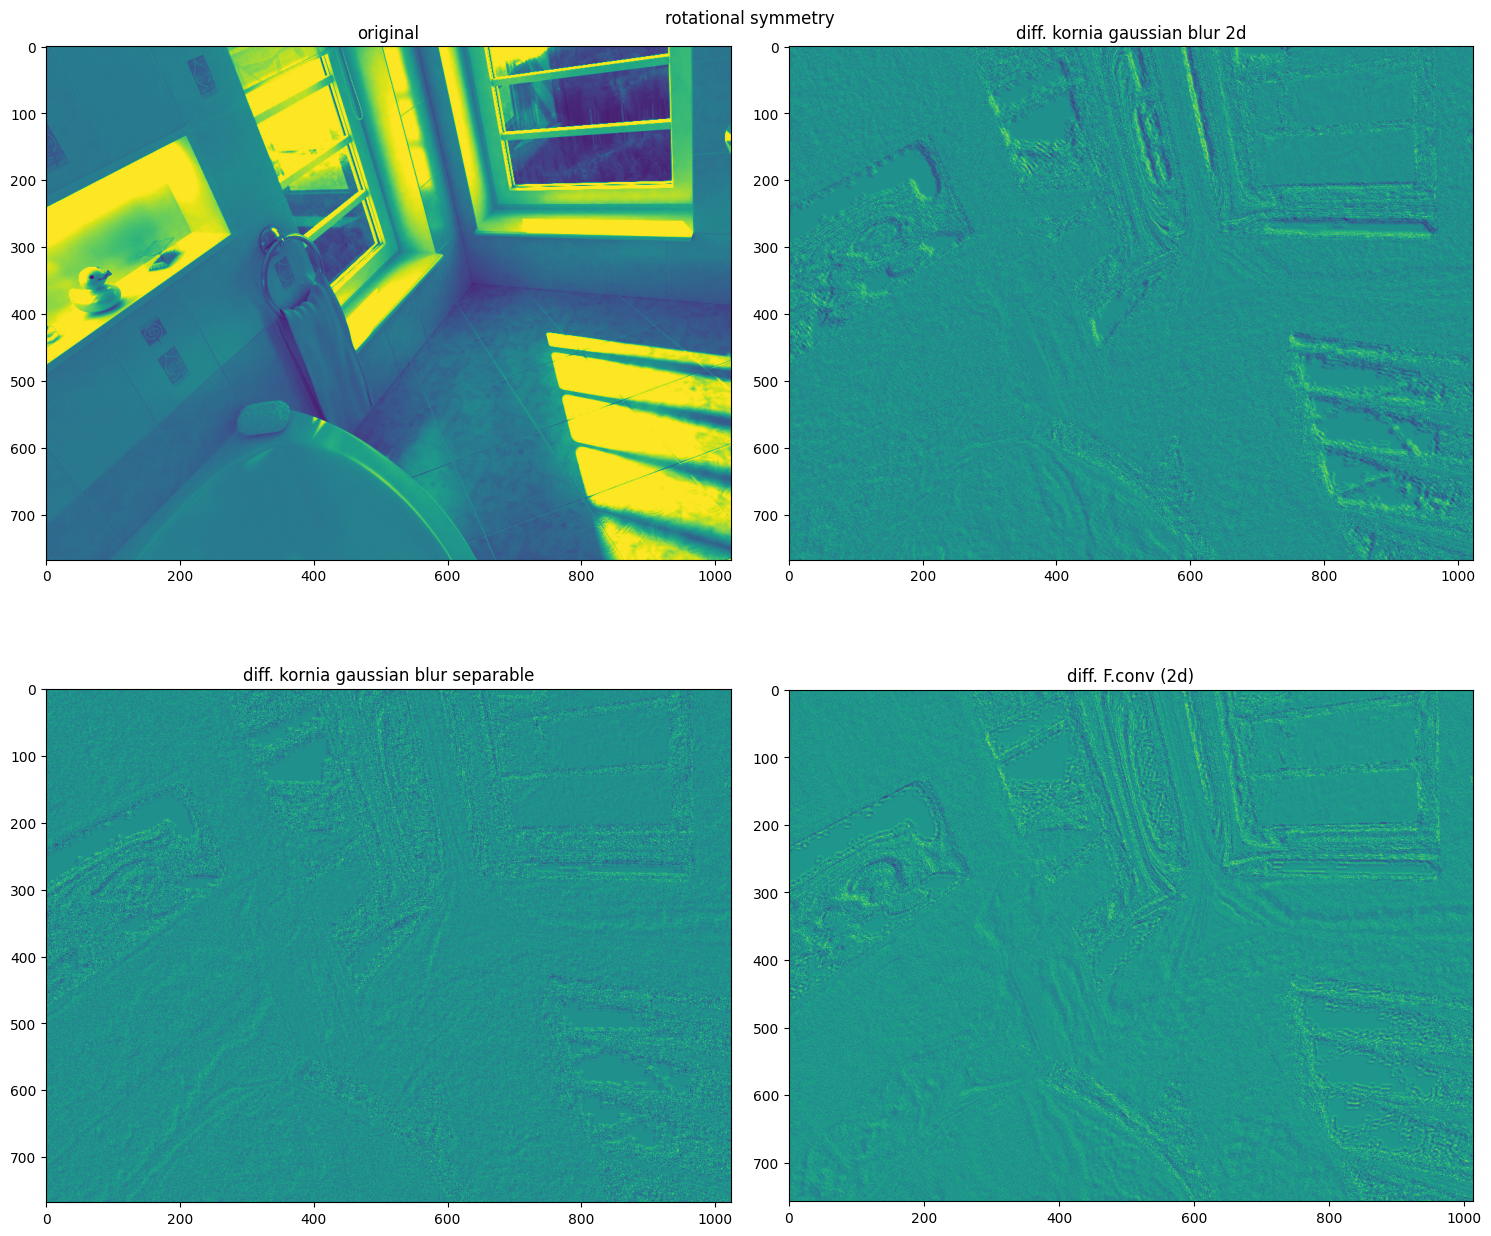

In [7]:
import os
import numpy as np
import torch

from PIL import Image

import torch.nn.functional as F

from kornia.filters import gaussian_blur2d
import kornia.utils as KU
from img_utils import show_torch
import matplotlib.pyplot as plt


def prepare(title, rows=2, cols=2):

    fig, axs = plt.subplots(rows, cols, figsize=(15, 13))
    fig.tight_layout()
    fig.suptitle(title)
    return axs


def add(axs, r, c, img, title):
    img = img[0, 0]
    axis = axs[r, c]
    axis.set_title(title)
    axis.imshow(img)


def get_kernel_size(sigma: float):
    ksize = int(2.0 * 4.0 * sigma + 1.0)

    if ksize % 2 == 0:
        ksize += 1
    return ksize


def kornia_gaussian_blur2d(x, sigma, separable=True):
    ksize = get_kernel_size(sigma)
    return gaussian_blur2d(x, (ksize, ksize), (sigma, sigma), separable=separable)


def rotate_experiment_gauss(file_path, rotations_90_deg):

    sigma = 1.25

    img_np_o = np.array(Image.open(file_path))
    img_t_o = KU.image_to_tensor(img_np_o.copy(), False).float() / 255.
    img_t_r = torch.rot90(img_t_o, k=rotations_90_deg, dims=(2, 3))

    loaded_kernel = torch.load('demo_imgs/torch_data/kernel2d.pt')
    loaded_kernel_rot = torch.rot90(loaded_kernel, 1, (2, 3))
    assert torch.all(loaded_kernel == loaded_kernel_rot)
    print("kernel unchanged when rotated by 90")

    img_t_o_g_2d = kornia_gaussian_blur2d(img_t_o, sigma, separable=False)
    img_t_o_sep = kornia_gaussian_blur2d(img_t_o, sigma, separable=True)
    img_t_o_F_conv_2d = F.conv2d(img_t_o, loaded_kernel, groups=loaded_kernel.size(0), padding=0, stride=1)

    img_t_r_g_2d = kornia_gaussian_blur2d(img_t_r, sigma, separable=False)
    img_t_r_sep = kornia_gaussian_blur2d(img_t_r, sigma, separable=True)
    img_t_r_F_conv_2d = F.conv2d(img_t_r, loaded_kernel, groups=loaded_kernel.size(0), padding=0, stride=1)

    img_t_b_g_2d = torch.rot90(img_t_r_g_2d, k=4 - rotations_90_deg, dims=(2, 3))
    img_t_b_sep = torch.rot90(img_t_r_sep, k=4 - rotations_90_deg, dims=(2, 3))
    img_t_b_F_conv_2d = torch.rot90(img_t_r_F_conv_2d, k=4 - rotations_90_deg, dims=(2, 3))

    img_t_d_g_2d = img_t_o_g_2d - img_t_b_g_2d
    img_t_d_sep = img_t_o_sep - img_t_b_sep
    img_t_d_F_conv_2d = img_t_o_F_conv_2d - img_t_b_F_conv_2d

    axs = prepare("rotational symmetry", rows=2, cols=2)
    add(axs, 0, 0, img_t_o, "original")
    add(axs, 0, 1, img_t_d_g_2d, "diff. kornia gaussian blur 2d")
    add(axs, 1, 0, img_t_d_sep, "diff. kornia gaussian blur separable")
    add(axs, 1, 1, img_t_d_F_conv_2d, "diff. F.conv (2d)")
    plt.show()


def rotate_experiment_loop_gauss(img_to_show):

    img_dir = "demo_imgs/hypersim"
    files = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][:img_to_show]
    for file_path in files:
        print(f"\n\nFILE: {file_path}\n")
        for rots in range(1, 4):
            print(f"rotation by {rots * 90} degrees")
            rotate_experiment_gauss(file_path, rots)


rotate_experiment_loop_gauss(img_to_show=1)
